In [1]:
import os
import pandas as pd

IN_PATH = os.path.join("..", "data", "processed", "spy_features_step4.csv")

# Columns we expect to exist based on Session 4
REQUIRED = ["Date", "y", "sma_5_ratio", "sma_10_ratio", "sma_20_ratio"]

In [2]:
df = pd.read_csv(IN_PATH, parse_dates=["Date"], date_format="%Y-%m-%d")

missing = [c for c in REQUIRED if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

df.head(3)

,Date,Close,High,Low,Open,Volume,return_1d,y,sma_5,sma_5_ratio,sma_10,sma_10_ratio,sma_20,sma_20_ratio
0,2010-01-04,85.515656,85.560928,84.142335,84.791267,118944600,0.002647,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,85.742020,85.779751,85.153454,85.462832,111579900,0.000704,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,85.802368,86.013647,85.591089,85.658998,116074400,0.004221,1,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data = (
    df[REQUIRED]              # only the columns we need downstream
      .sort_values("Date")    # chronological order to avoid leakage later
      .dropna()               # remove early-window NaNs from SMA features
      .reset_index(drop=True)
)

print("Rows:", len(data))
print("Date range:", data["Date"].min().date(), "→", data["Date"].max().date())

print("\nLabel counts:")
print(data["y"].value_counts().rename({0: "down", 1: "up"}))

print("\nLabel distribution (%):")
print((data["y"].value_counts(normalize=True) * 100).round(2))

data.head(5)

Rows: 3754
Date range: 2010-02-01 → 2024-12-30

Label counts:
y
up      2075
down    1679
Name: count, dtype: int64

Label distribution (%):
y
1    55.27
0    44.73
Name: proportion, dtype: float64


,Date,y,sma_5_ratio,sma_10_ratio,sma_20_ratio
0,2010-02-01,1,1.002095,0.988050,0.971668
1,2010-02-02,0,1.012233,1.004267,0.984722
2,2010-02-03,0,1.007190,1.002968,0.981479
3,2010-02-04,1,0.979930,0.976702,0.954285
4,2010-02-05,0,0.983277,0.981016,0.959497


In [4]:
import pandas as pd

SPLIT_DATE = pd.Timestamp("2021-01-01")   # adjust later if you want

FEATURES = ["sma_5_ratio", "sma_10_ratio", "sma_20_ratio"]
TARGET   = "y"

train = data[data["Date"] < SPLIT_DATE].copy()
test  = data[data["Date"] >= SPLIT_DATE].copy()

X_train, y_train = train[FEATURES], train[TARGET]
X_test,  y_test  = test[FEATURES],  test[TARGET]

print("Train:", train["Date"].min().date(), "→", train["Date"].max().date(), "| n:", len(train))
print("Test: ", test["Date"].min().date(),  "→", test["Date"].max().date(),  "| n:", len(test))

assert train["Date"].max() < test["Date"].min(), "Leakage risk: overlapping dates."
assert len(train) > 0 and len(test) > 0, "Empty split—adjust SPLIT_DATE."

Train: 2010-02-01 → 2020-12-31 | n: 2750
Test:  2021-01-04 → 2024-12-30 | n: 1004


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

logreg_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=2000))])

In [6]:
logreg_pipe.fit(X_train, y_train)

# Quick check: model is trained if no errors were raised.
print("Model fitted. Coefficients shape:", logreg_pipe.named_steps["clf"].coef_.shape)

Model fitted. Coefficients shape: (1, 3)


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_pred  = logreg_pipe.predict(X_test)
y_proba = logreg_pipe.predict_proba(X_test)[:, 1]

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
rocauc    = roc_auc_score(y_test, y_proba)
cm        = confusion_matrix(y_test, y_pred)

print({
    "accuracy": round(accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1": round(f1, 4),
    "roc_auc": round(rocauc, 4),
    "test_n": len(y_test),
    "split_date": str(SPLIT_DATE.date())
})
print("\nConfusion matrix:\n", cm)

{'accuracy': 0.5408, 'precision': 0.5408, 'recall': 1.0, 'f1': 0.702, 'roc_auc': 0.4931, 'test_n': 1004, 'split_date': '2021-01-01'}

Confusion matrix:
 [[  0 461]
 [  0 543]]


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

rf_metrics = {
    "model": "random_forest",
    "accuracy": round(accuracy_score(y_test, y_pred_rf), 4),
    "precision": round(precision_score(y_test, y_pred_rf), 4),
    "recall": round(recall_score(y_test, y_pred_rf), 4),
    "f1": round(f1_score(y_test, y_pred_rf), 4),
    "roc_auc": round(roc_auc_score(y_test, y_proba_rf), 4),
    "test_n": len(y_test)
}
print(rf_metrics)

{'model': 'random_forest', 'accuracy': 0.504, 'precision': 0.5341, 'recall': 0.6483, 'f1': 0.5857, 'roc_auc': 0.4937, 'test_n': 1004}


In [9]:
import pandas as pd

logreg_metrics = {
    "model": "logreg",
    "accuracy": round(accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1": round(f1, 4),
    "roc_auc": round(rocauc, 4),
    "test_n": len(y_test)
}

results = pd.DataFrame([logreg_metrics, rf_metrics]).sort_values("roc_auc", ascending=False)
results

,model,accuracy,precision,recall,f1,roc_auc,test_n
1,random_forest,0.5040,0.5341,0.6483,0.5857,0.4937,1004
0,logreg,0.5408,0.5408,1.0000,0.7020,0.4931,1004


<Figure size 600x500 with 0 Axes>

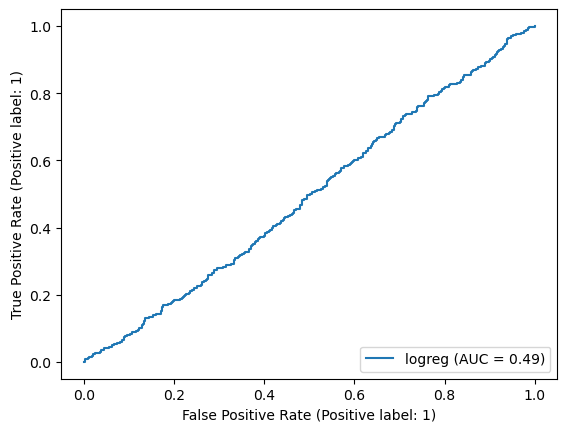

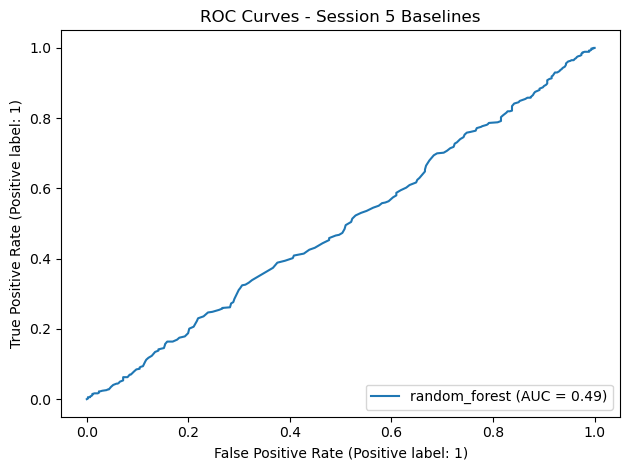

In [13]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba, name="logreg")
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name="random_forest")
plt.title("ROC Curves - Session 5 Baselines")
plt.tight_layout(); plt.show()

In [11]:
import numpy as np

fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)
fi

,feature,importance
0,sma_5_ratio,0.335122
2,sma_20_ratio,0.332860
1,sma_10_ratio,0.332018


In [12]:
import os, joblib
OUT_DIR = os.path.join("..", "artifacts", "session5_baseline")
os.makedirs(OUT_DIR, exist_ok=True)

results.to_csv(os.path.join(OUT_DIR, "baseline_metrics.csv"), index=False)
joblib.dump(logreg_pipe, os.path.join(OUT_DIR, "logreg_model.joblib"))
joblib.dump(rf,          os.path.join(OUT_DIR, "rf_model.joblib"))

session_log = {
    "session": "Session 5 — Baseline Modeling",
    "features": list(X_train.columns),
    "split_date": str(SPLIT_DATE.date()),
    "artifacts": {
        "metrics_csv": "baseline_metrics.csv",
        "models": ["logreg_model.joblib", "rf_model.joblib"]
    },
    "notes": [
        "Time-based split; no shuffling.",
        "Two baselines trained: LogisticRegression (with scaling) and RandomForest.",
        "See ROC curves and confusion matrices for error profiles."
    ]
}
pd.Series(session_log)

session                           Session 5 — Baseline Modeling
features              [sma_5_ratio, sma_10_ratio, sma_20_ratio]
split_date                                           2021-01-01
artifacts     {'metrics_csv': 'baseline_metrics.csv', 'model...
notes         [Time-based split; no shuffling., Two baseline...
dtype: object